## Casting a Classifier into a Fully Convolutional Network

Let's take the vgg16 net and transform it into a fully convolutional net for efficient, dense inference on large inputs. This model generates a classification map that covers a given input size instead of a single classification. In particular a 26 $\times$ 26 classification map on a 1024 $\times$ 1024 input gives 676x the output in only Xx the time. The computation exploits a natural efficiency of convolutional network (convnet) structure by amortizing the computation of overlapping receptive fields.

To do so we translate the `InnerProduct` matrix multiplication layers of CaffeNet into `Convolutional` layers. This is the only change: the other layer types are agnostic to spatial size. Convolution is translation-invariant, activations are elementwise operations, and so on. The `fc6` inner product when carried out as convolution by `fc6-conv` turns into a 7 \times 7 filter with stride 1 on `pool5`. Back in image space this gives a classification for each 224 $\times$ 224 box with stride 32(because a neuron of `pool5` is scale of 2^5 pixels) in pixels. Remember the equation for output map / receptive field size, output = (input - kernel_size) / stride + 1(i.e. 26 = (1024-224) / 32 + 1), and work out the indexing details for a clear understanding.

The only differences needed in the architecture are to change the fully connected classifier inner product layers into convolutional layers with the right filter size -- 7 x 7, since the reference model classifiers take the 49 elements of `pool5` as input -- and stride 1 for dense classification. Note that the layers are renamed so that Caffe does not try to blindly load the old parameters when it maps layer names to the pretrained model.

In [1]:
import numpy as np
import PIL.Image

caffe_root = '/works/caffe/'
import sys; sys.path.insert(0, caffe_root + 'python')
import caffe; caffe.set_mode_cpu()

# Load the original network and extract the fully connected layers' parameters.
MODEL_DEPLOY_FILENAME = caffe_root + 'models/vgg/vgg_layer16_deploy.prototxt'
MODEL_WEIGHT_FILENAME = caffe_root + 'models/vgg/vgg_layer16.caffemodel'
net = caffe.Net(MODEL_DEPLOY_FILENAME, MODEL_WEIGHT_FILENAME, caffe.TEST)
params = ['fc6', 'fc7', 'fc8']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
  print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

fc6 weights are (4096, 25088) dimensional and biases are (4096,) dimensional
fc7 weights are (4096, 4096) dimensional and biases are (4096,) dimensional
fc8 weights are (1000, 4096) dimensional and biases are (1000,) dimensional


Consider the shapes of the inner product parameters. The weight dimensions are the output and input sizes while the bias dimension is the output size.

In [2]:
# Load the fully convolutional network to transplant the parameters.
MODEL_FCN_DEPLOY_FILENAME = caffe_root + 'models/vgg/vgg_layer16_deploy_fcn.prototxt'
MODEL_FCN_WEIGHT_FILENAME = caffe_root + 'models/vgg/vgg_layer16.caffemodel'
net_full_conv = caffe.Net(MODEL_FCN_DEPLOY_FILENAME, MODEL_FCN_WEIGHT_FILENAME, caffe.TEST)
params_full_conv = ['fc6_conv', 'fc7_conv', 'fc8_conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
  print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

fc6_conv weights are (4096, 512, 7, 7) dimensional and biases are (4096,) dimensional
fc7_conv weights are (4096, 4096, 1, 1) dimensional and biases are (4096,) dimensional
fc8_conv weights are (1000, 4096, 1, 1) dimensional and biases are (1000,) dimensional


The convolution weights are arranged in output $\times$ input $\times$ height $\times$ width dimensions. To map the inner product weights to convolution filters, we could roll the flat inner product vectors into channel $\times$ height $\times$ width filter matrices, but actually these are identical in memory (as row major arrays) so we can assign them directly.

The biases are identical to those of the inner product.

Let's transplant!

In [3]:
# transplant
for pr, pr_conv in zip(params, params_full_conv):
  conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
  conv_params[pr_conv][1][...] = fc_params[pr][1]

Next, save the new model weights.

In [4]:
net_full_conv.save(caffe_root + 'models/vgg/vgg_layer16_fcn.caffemodel')

To conclude, let's make a classification map from the example cat image and visualize the confidence of "tiger cat" as a probability heatmap. This gives an 8-by-8 prediction on overlapping regions of the 451 $\times$ 451 input.

[[782 782 782 782 782 662 681 418 767 767 767 767 767 767 767 767 623 623
  623  69 478 478 478 478 478 478]
 [605 605 605 605 681 681 508 508 767 767 418 767 767 767 767 767 767 961
  961 961 961 478 478 478 478 478]
 [605 605 605 681 508 508 508 508 769 769 418 418 418 418 418 767 767 767
  961 961 961 767 767 478 478 478]
 [605 605 605 605 549 549 508 769 769 769 905 681 662 662 662 662 662 767
  767 767 767 767 767 767 478 478]
 [785 605 605 549 549 549 549 549 549 905 905 905 905 662 662 662 662 662
  662 418 418 767 767 767 767 478]
 [785 785 605 549 549 549 549 549 549 446 905 905 905 905 905 905 662 605
  605 605 418 418 418 767 767 478]
 [785 664 549 549 549 549 549 549 549 794 905 905 905 905 905 905 905 799
  799 605 605 605 769 769 769 844]
 [785 446 446 549 549 549 549 549 549 905 905 905 905 905 905 905 905 799
  799 799 605 605 605 605 605 605]
 [446 446 446 446 446 446 446 446 446 794 905 905 266 266 333 333 710 710
  700 700 999 799 905 605 605 605]
 [446 446 662 898 4

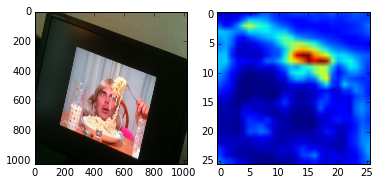

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

dataset_root = '/storage/CDVS_Dataset/'
# load input and configure preprocessing
im = caffe.io.load_image(dataset_root + 'video/Queries/smvs_video_frames_iPhone_024.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load(caffe_root + '/python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
plt.subplot(1, 2, 2)
_=plt.imshow(out['prob'][0,281])
#_=plt.imshow(out['prob'][0,999])
print 'im: {}, pool5: {}, out: {}'.format(net_full_conv.blobs['data'].data[0].shape, net_full_conv.blobs['pool5'].data.shape, out['prob'][0].shape)
size_input = net_full_conv.blobs['data'].data[0].shape[1]
print 'size_output: %d = (%d-224) / %d + 1' % ((size_input-224)/2**5 + 1, size_input, 2**5)

The classifications include various cats -- 282 = tiger cat, 281 = tabby, 283 = persian -- and foxes and other mammals.

In this way the fully connected layers can be extracted as dense features across an image (see `net_full_conv.blobs['fc6'].data` for instance), which is perhaps more useful than the classification map itself.

Note that this model isn't totally appropriate for sliding-window detection since it was trained for whole-image classification. Nevertheless it can work just fine. Sliding-window training and finetuning can be done by defining a sliding-window ground truth and loss such that a loss map is made for every location and solving as usual. (This is an exercise for the reader.)

*A thank you to Rowland Depp for first suggesting this trick.*

In [2]:
import numpy as np
import PIL.Image

caffe_root = '/works/caffe/'
import sys; sys.path.insert(0, caffe_root + 'python')
import caffe; caffe.set_mode_cpu()

# Load the original network and extract the fully connected layers' parameters.
MODEL_DEPLOY_FILENAME = caffe_root + 'models/bvlc_googlenet/deploy.prototxt'
MODEL_WEIGHT_FILENAME = caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'
net = caffe.Net(MODEL_DEPLOY_FILENAME, MODEL_WEIGHT_FILENAME, caffe.TEST)
params = ['loss3/classifier']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
  print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

loss3/classifier weights are (1000, 1024) dimensional and biases are (1000,) dimensional


In [ ]:
# Load the fully convolutional network to transplant the parameters.
MODEL_FCN_DEPLOY_FILENAME = caffe_root + 'models/bvlc_googlenet/deploy_fcn.prototxt'
MODEL_FCN_WEIGHT_FILENAME = caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'
net_full_conv = caffe.Net(MODEL_FCN_DEPLOY_FILENAME, MODEL_FCN_WEIGHT_FILENAME, caffe.TEST)
params_full_conv = ['loss3/classifier']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
  print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)